# SETUP

In [10]:
import dotenv

dotenv.load_dotenv()

True

In [11]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

In [12]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

# Document loader

In [14]:
from langchain_community.document_loaders import ObsidianLoader

In [15]:
loader = ObsidianLoader(r"/mnt/c/Users/luisl/Documents/Life itself")
docs = loader.load()

In [16]:
print(f"Number of documents loaded: {len(docs)}")
print("\nFirst few documents preview:")
for i, doc in enumerate(docs[:3]):
    print(f"\nDocument {i+1}:")
    print(f"Source: {doc.metadata.get('source', 'No source')}")
    print(f"Content preview: {doc.page_content[:200]}...")

Number of documents loaded: 256

First few documents preview:

Document 1:
Source: Home 🛋️.md
Content preview: tags: [[Administración]]

[[Finanzas]]
[[Nutrición]]
- [[Lista de compras - mandado]]
- [[Ejercicio]]
- meal prep 
- desayuno, comida, cena

[[Goals]]
- comprarme una pc
- fashion
- dibujo

- [[Estudi...

Document 2:
Source: 1ero planes a futuro.md
Content preview: 2024-11-22 14:59

Status:

Tags: [[1. Raw/1ero trader|1ero trader]]

# 1ero planes a futuro


# Plan de Mejora del Proyecto
## 1. Brechas en Recolección de Información
### 1.1 Manejo de Información Te...

Document 3:
Source: 1ero trader mongoDB.md
Content preview: 2024-11-11 11:53

Status:

Tags: [[1. Raw/1ero trader]]

# 1ero trader mongoDB

Tickers
object example:
```JSON
{
  "_id": {
    "$oid": "651189993ed6e56a7ba6f49a"
  },
  "symbol": "IPOOF",
  "beta": ...


# Splitter

In [17]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)

# Process each document separately
all_splits = []
for doc in docs:
    splits = text_splitter.split_documents([doc])
    # Ensure each split retains the original document source
    for split in splits:
        split.metadata['source'] = doc.metadata.get('source', 'No source')
    all_splits.extend(splits)

print(f"Split documents into {len(all_splits)} chunks while preserving original sources.")

Split documents into 861 chunks while preserving original sources.


# Vector store

In [18]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from uuid import uuid4

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = Chroma(
    collection_name="obsidian_docs",
    embedding_function=embeddings,
    persist_directory="./chroma_obsidian_db"
)

# Add documents and get their IDs
document_ids = [str(uuid4()) for _ in range(len(all_splits))]
vector_store.add_documents(documents=all_splits, ids=document_ids)

print("First few document IDs:")
print(document_ids[:3])

First few document IDs:
['8eae3bfb-6e77-4378-98fb-ed4cf29cc1ab', '1b0ee9d4-79eb-41de-ba6c-f357f8a10bc0', '9befee2d-66c1-40f2-8f6a-59f227d8dd44']


# Retrieval and generation

In [4]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [1]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [2]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [3]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

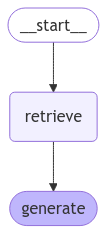

In [5]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
result = graph.invoke({"question": "give me a summary of the content available. all the topics talked about"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(metadata={'created': 1729579863.116958, 'last_accessed': 1733470529.1726046, 'last_modified': 1729272914.374, 'path': '/mnt/c/Users/luisl/Documents/Life itself/1. Raw/AWS learning.md', 'source': 'AWS learning.md', 'start_index': 637}, page_content='**Week 2: AWS Compute & Networking**\n\nWeek 2 is where you will learn how AWS compute services differ from other AWS services. The content for this week covers the basic components of Amazon Elastic Compute Cloud (Amazon EC2) architecture, and how to differentiate between a container and a virtual machine. You will also learn about the features and advantages of using serverless technologies, in addition to basic networking concepts and the features of Amazon Virtual Private Cloud (Amazon VPC).\n\n**Week 3: Storage & Databases on AWS**\n\nThis week, you will learn important concepts for AWS storage services—such as buckets and objects for Amazon Simple Storage Service (Amazon S3), and how Amazon Elastic Block Store (Amazo

# Writer

In [18]:
def write_to_obsidian(state: State):
    """Write the question and answer to an Obsidian note."""
    from datetime import datetime
    import os
    
    # Configure test vault path in a separate directory
    OBSIDIAN_TEST_VAULT = r"/mnt/c/Users/luisl/Documents/AI_Generated_Notes"
    
    # Create filename based on question
    safe_filename = "".join(x for x in state["question"][:50] if x.isalnum() or x in " -_").strip()
    filename = f"{datetime.now().strftime('%Y%m%d')}-{safe_filename}.md"
    filepath = os.path.join(OBSIDIAN_TEST_VAULT, filename)
    
    # Format the note content with frontmatter and content
    note_content = f"""---
created: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
tags: [ai-generated, test-notes]
---

# {state["question"]}

{state["answer"]}

## Sources
"""
    
    # Add sources from context
    for doc in state["context"]:
        note_content += f"\n- {doc.metadata.get('source', 'Unknown source')}"
    
    # Write to file
    os.makedirs(OBSIDIAN_TEST_VAULT, exist_ok=True)
    with open(filepath, "w", encoding="utf-8") as f:
        f.write(note_content)
    
    return {"obsidian_file": filepath}

# Update the graph to include the writing step
graph_builder = StateGraph(State).add_sequence([retrieve, generate, write_to_obsidian])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()


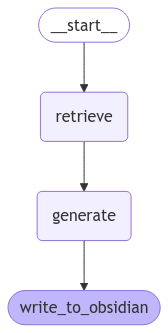

In [19]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
result = graph.invoke({"question": "what content do you have available for meal preparation?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(metadata={'created': 1730764614.8512337, 'last_accessed': 1733470527.3838358, 'last_modified': 1730695277.836, 'path': '/mnt/c/Users/luisl/Documents/Life itself/Resources/platillos nuevos.md', 'source': 'platillos nuevos.md', 'start_index': 0, 'tags': 'child'}, page_content='2024-09-14 20:58\n\nStatus: #child \n\nTags: [[Rutina de salud 🫀]] [[Nutrición]]\n\n# posibles platillos nuevos\nPan frances\nLentejas\nCamarones roca\nCeviche\n\n### Nombres de recetas\n**chocolate chip cookie brittle**\n **blackberry fool**'), Document(metadata={'created': 1730764614.8512337, 'last_accessed': 1733470527.3838358, 'last_modified': 1730695277.836, 'path': '/mnt/c/Users/luisl/Documents/Life itself/Resources/platillos nuevos.md', 'source': 'platillos nuevos.md', 'start_index': 0, 'tags': 'child'}, page_content='2024-09-14 20:58\n\nStatus: #child \n\nTags: [[Rutina de salud 🫀]] [[Nutrición]]\n\n# posibles platillos nuevos\nPan frances\nLentejas\nCamarones roca\nCeviche\n\n### Nombres

# Vault manager

In [21]:
class TestVaultManager:
    def __init__(self, vault_path: str, vector_store: Chroma):
        self.vault_path = vault_path
        self.vector_store = vector_store
        self.file_to_ids = {}  # Keep track of which IDs belong to which files
        
    def add_note(self, title: str, content: str) -> str:
        """Add a new note and its vectors"""
        # Create file path
        file_path = os.path.join(self.vault_path, f"{title}.md")
        
        # Create document and get its ID
        doc = Document(page_content=content, metadata={"source": {title}})
        doc_id = str(uuid4())
        
        # Save to Obsidian
        with open(file_path, "w") as f:
            f.write(content)
            
        # Save to vector store
        self.vector_store.add_documents([doc], ids=[doc_id])
        self.file_to_ids[file_path] = doc_id
        
        return doc_id

In [22]:
import os

# Initialize test environment
test_vault_path = "./test_vault"
os.makedirs(test_vault_path, exist_ok=True)

test_vector_store = Chroma(
    collection_name="test_vault",
    embedding_function=embeddings,
    persist_directory="./test_chroma_db"
)

vault_manager = TestVaultManager(test_vault_path, test_vector_store)

# Create a test note
note_id = vault_manager.add_note(
    "test_note",
    """# Test Note
    This is a test note to understand vector store management.
    """
)

In [43]:
def parse_obsidian_note(doc):
    """Parse a single Obsidian note and extract its components"""
    import re
    from datetime import datetime
    
    content = doc.page_content
    
    # Define regex patterns
    date_pattern = r"(\d{4}-\d{2}-\d{2}\s+\d{2}:\d{2})"
    status_pattern = r"Status:\s*#(\w+)"
    tags_pattern = r"Tags:\s*((?:\[\[.*?\]\](?:\s|$))*)"
    wikilink_pattern = r"\[\[(.*?)\]\]"
    title_pattern = r"#\s+(.+)$"
    
    # Extract components
    date_match = re.search(date_pattern, content)
    date = datetime.strptime(date_match.group(1), "%Y-%m-%d %H:%M") if date_match else None
    
    status_match = re.search(status_pattern, content)
    status = status_match.group(1) if status_match else None
    
    tags_match = re.search(tags_pattern, content)
    tags = []
    if tags_match:
        tags_section = tags_match.group(1)
        tags = re.findall(wikilink_pattern, tags_section)
    
    # Extract title (first # heading)
    title_match = re.search(title_pattern, content, re.MULTILINE)
    title = title_match.group(1) if title_match else "Untitled"
    
    # Extract actual content (everything after the title)
    content_parts = content.split("\n# " + title)
    actual_content = content_parts[1].strip() if len(content_parts) > 1 else ""
    
    return {
        "date": date,
        "status": status,
        "tags": tags,
        "title": title,
        "source_path": doc.metadata.get('source', ''),
        "content": actual_content
    }

In [44]:
# Test the parser with first document
first_doc = docs[125]
parsed = parse_obsidian_note(first_doc)

print("Parsed Note:")
print(f"Date: {parsed['date']}")
print(f"Status: {parsed['status']}")
print(f"Tags: {parsed['tags']}")
print(f"Title: {parsed['title']}")
print(f"Source: {parsed['source_path']}")

Parsed Note:
Date: 2024-06-19 11:06:00
Status: teen
Tags: ['Información', 'ML']
Title: Github repos similares
Source: Github repos similares de interactionAI.md


In [47]:
from langchain_core.prompts import ChatPromptTemplate

classification_prompt = ChatPromptTemplate.from_template(
    """You are a document classifier. Given a note's title and content, classify it according to our hierarchical taxonomy.
    Return ONLY the most specific and relevant category codes (maximum 3).
    
    If you find that the note content would be better served by a new category that doesn't exist in the taxonomy,
    suggest it using the format NEW-CAT: TEC-GIT-REP (Git Repository Management).

    Taxonomy:
    Technical (TEC):
    - Programming (TEC-PRO): Languages (TEC-PRO-PY, JS), Frameworks (TEC-PRO-REA, TF), Development (TEC-PRO-SDP)
    - Mathematics (TEC-MAT): Pure (TEC-MAT-ALG, CAL), Applied (TEC-MAT-STA)
    - Machine Learning (TEC-ML): Algorithms (TEC-ML-SUP, UNS), Applications (TEC-ML-NLP, CV)
    
    Personal Development (PER):
    - Learning (PER-LEA): Strategies (PER-LEA-SPR), Cognition (PER-LEA-COG), Memory (PER-LEA-MEM)
    - Information (PER-INF): Knowledge Management (PER-INF-KM), Note-Taking (PER-INF-NOT)
    - Productivity (PER-PRO): Goals (PER-PRO-GOA), Time Management (PER-PRO-TIM)
    
    Lifestyle (LIF):
    - Health (LIF-HEA): Exercise (LIF-HEA-EXE), Nutrition (LIF-HEA-NUT), Mental (LIF-HEA-MEN)
    - Finance (LIF-FIN): Budgeting (LIF-FIN-BUD), Investing (LIF-FIN-INV)
    - Entertainment (LIF-ENT): Media (LIF-ENT-BOO, MOV), Hobbies (LIF-ENT-HOB)

    Note Title: {title}
    Note Content: {content}

    Return only the category codes, separated by spaces. If suggesting new categories, add them after existing codes.
    Example: TEC-ML-CV TEC-ML-PYT NEW-CAT: TEC-GIT-REP (Git Repository Management)
    Categories:""")

def classify_note(llm, title, content):
    """Use LLM to classify note content into our taxonomy"""
    response = llm.invoke(classification_prompt.format(
        title=title,
        content=content[:1000]  # Limit content length
    ))
    
    # Split and clean the response
    categories = []
    parts = response.content.strip().split()
    
    for part in parts:
        # Skip parenthetical explanations and NEW-CAT markers
        if part.startswith('(') or part == 'NEW-CAT:':
            continue
        # Only add valid category codes
        if '-' in part and any(part.startswith(prefix) for prefix in ['TEC', 'PER', 'LIF']):
            categories.append(part)
            
    return categories

In [48]:
def transform_note(parsed_note, concepts):
    """Transform parsed note into new format with YAML frontmatter"""
    # Format the date from parsed note
    created_date = parsed_note['date'].strftime("%Y-%m-%dT%H:%M") if parsed_note['date'] else datetime.now().strftime("%Y-%m-%dT%H:%M")
    
    # Format concepts with # prefix, filtering out any malformed ones
    formatted_concepts = ' '.join(f"#{concept}" for concept in concepts 
                                if '-' in concept and any(concept.startswith(prefix) 
                                for prefix in ['TEC', 'PER', 'LIF']))
    
    # Create the YAML frontmatter
    yaml_header = f"""---
created: {created_date}
status: {parsed_note['status'] or 'child'}
concepts: {formatted_concepts}
---"""
    
    # Format tags with wiki-links
    tags_line = f"Tags: {' '.join('[[' + tag + ']]' for tag in parsed_note['tags'])}" if parsed_note['tags'] else ""
    
    # Combine all parts
    new_content = f"{yaml_header}\n\n{tags_line}\n\n# {parsed_note['title']}\n\n{parsed_note['content']}"
    
    return new_content

In [49]:
# Process a single note
test_doc = docs[125]
parsed = parse_obsidian_note(test_doc)
concepts = classify_note(llm, parsed['title'], parsed['content'])
new_note = transform_note(parsed, concepts)

print("Transformed Note:")
print(new_note)

Transformed Note:
---
created: 2024-06-19T11:06
status: teen
concepts: #TEC-PRO-REP #TEC-GIT-REP
---

Tags: [[Información]] [[ML]]

# Github repos similares

https://github.com/asingh33/CNNGestureRecognizer


https://github.com/vladmandic/human

https://github.com/JoseExposito/touchegg
.
https://arxiv.org/archive/cs.CV


https://pyimagesearch.com/2019/09/02/opencv-stream-video-to-web-browser-html-page/


In [41]:
print(concepts)

['TEC-ML-CV', 'TEC-ML-UNS', 'NEW-CAT:', 'TEC-GIT-REP', '(Git', 'Repository', 'Management)']


In [52]:
from datetime import datetime
class TestVaultManager:
    def __init__(self, vault_path: str, vector_store: Chroma):
        self.vault_path = vault_path
        self.vector_store = vector_store
        self.file_to_ids = {}  # Keep track of which IDs belong to which files
        
    def process_vault(self, docs):
        """Process all documents in the vault"""
        # Generate UUIDs for all documents upfront
        document_ids = [str(uuid4()) for _ in range(len(docs))]
        processed_documents = []
        
        for doc, doc_id in zip(docs, document_ids):
            try:
                # Parse the note
                parsed = parse_obsidian_note(doc)
                
                # Get concepts from LLM
                concepts = classify_note(llm, parsed['title'], parsed['content'])
                
                # Transform note content
                new_note = transform_note(parsed, concepts)
                
                # Create metadata for vector store
                metadata = {
                    "title": parsed['title'],
                    "created": parsed['date'].isoformat() if parsed['date'] else None,
                    "status": parsed['status'],
                    "concepts": concepts,
                    "tags": parsed['tags'],
                    "source_path": parsed['source_path']
                }
                
                # Create safe filename
                safe_title = "".join(x for x in parsed['title'] if x.isalnum() or x in " -_").strip()
                file_path = os.path.join(self.vault_path, f"{safe_title}.md")
                
                # Save to Obsidian
                with open(file_path, "w", encoding="utf-8") as f:
                    f.write(new_note)
                
                # Create document for vector store
                processed_documents.append(Document(
                    page_content=parsed['content'],
                    metadata=metadata
                ))
                
                # Track file to UUID mapping
                self.file_to_ids[file_path] = doc_id
                
            except Exception as e:
                print(f"Error processing document: {e}")
                
        # Add all documents to vector store at once
        if processed_documents:
            self.vector_store.add_documents(
                documents=processed_documents,
                ids=document_ids[:len(processed_documents)]
            )
        
        return self.file_to_ids

# Initialize and use
test_vault_path = "/mnt/c/Users/luisl/Documents/AI_Generated_Notes"
os.makedirs(test_vault_path, exist_ok=True)

test_vector_store = Chroma(
    collection_name="test_vault",
    embedding_function=embeddings,
    persist_directory="./test_chroma_db"
)

vault_manager = TestVaultManager(test_vault_path, test_vector_store)

# Process all documents
file_to_id_mapping = vault_manager.process_vault(docs)

ValueError: Expected metadata value to be a str, int, float or bool, got None which is a NoneType in upsert.

Try filtering complex metadata from the document using langchain_community.vectorstores.utils.filter_complex_metadata.

# Query analyzer

In [1]:
import dotenv
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI

dotenv.load_dotenv()
llm = ChatOpenAI(model="gpt-4o-mini")
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [4]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [5]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

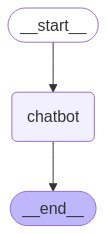

In [6]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break